# Example Classification from "Natural Language Processing with Transformers"

Source: https://github.com/nlp-with-transformers/notebooks

In [1]:
# Hugging Face Pckgs
from transformers import pipeline
from datasets import list_datasets
from datasets import load_dataset

# Loading weights from pretrained model
from transformers import AutoModel
# AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs
from transformers import AutoModelForSequenceClassification
# Defining Training Parameters
from transformers import Trainer, TrainingArguments
# Tokenizer for DistilBert
from transformers import AutoTokenizer


# Python Pckgs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Various metrics 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# PyTorch
import torch
from torch.nn.functional import cross_entropy

In [2]:
# Hugging Face Transformer method to list datasets avalaible on the hub
all_datasets = list_datasets()

In [3]:
# How many datasets are on the Hugging Face Hub?
print(len(all_datasets))

21729


In [4]:
# List ten frist datasets
all_datasets[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

## Loading Dataset

In [5]:
# Loading dataset "emotions" from the Hub
# Example from the book "Natural Language Processing with Transformers"

emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/aklof/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# look at the data structure
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
# Checking the traning part of the dataset
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

16.000 labeled Tweets are in the training dataset

In [8]:
# Access single element
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
train_ds.column_names

['text', 'label']

## Building Data Frame

In [10]:
# Change output format of the dataset
emotions.set_format(type="pandas")

In [11]:
# Putting train part of the dataset into dataframe
df_train = emotions["train"][:]

In [12]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
# Turning integers into strings/label names

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df_train["label_name"] = df_train["label"].apply(label_int2str)
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Analyzing dataset

### Class distribution

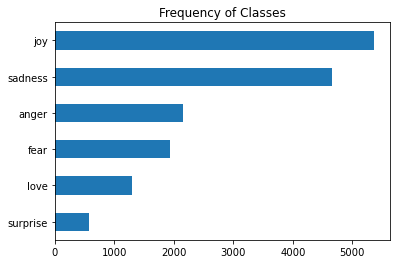

In [14]:
df_train["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()
     

Train dataset is unbalanced. This is not good for training our models. 

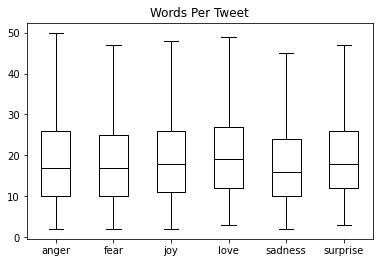

In [15]:
# Words per Tweet
df_train["Words Per Tweet"] = df_train["text"].str.split().apply(len)
df_train.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()
     


Transformers have a maximum input sequence length therfore it is necessary to check the length of the tweets. 

In [16]:
# Reseting dataframe format

emotions.reset_format()
     


## Tokenization

"Transformers provides a convenient AutoTokenizer class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its from_pretrained() method, providing the ID of a model on the Hub or a local file path."
https://github.com/nlp-with-transformers/notebooks/blob/main/02_classification.ipynb

"The AutoTokenizer class belongs to a larger set of "auto" classes whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well."

In [17]:
# Using Tokenizer from DistilBert
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
# Processing method to tokenize our examples
def tokenize(batch):
    return tokenizer(batch["text"],padding=True,truncation=True)

In [19]:
# Map method = "convenient way to apply a processing function to each element in a dataset"

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\aklof\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-4d924eeeec90cd77.arrow
Loading cached processed dataset at C:\Users\aklof\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-367f8aa48e7b479e.arrow
Loading cached processed dataset at C:\Users\aklof\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-49f8a4484df2386c.arrow


In [20]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training Classifier: Methods

### A: Feature Extraction

Using hidden states of a pretrained model as features. Part of the model´s parameter are being frozen. 
"we freeze the body's weights during training and use the hidden states as features for the classifier."

### 1. Defining and downloading pre-trained model

In [21]:
# Definig our pre-trained model
model_ckp = "distilbert-base-uncased"

In [22]:
# Using GPU if avalaible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AutoModel has a from_pretrained() method to load the weights of a pretrained model. 
The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states.
Let's take a look at how we can extract these states from our corpus.

In [23]:
# Returning hidden states with AutoModel
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
# Extracting last hidden states

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
     

Since our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:

In [25]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

### 2. Extracting hidden states

In [26]:
# extract the hidden states across all splits in one go
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Loading cached processed dataset at C:\Users\aklof\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-99024b6f28a1c486.arrow
Loading cached processed dataset at C:\Users\aklof\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-a50d7afa245b0491.arrow
Loading cached processed dataset at C:\Users\aklof\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-619b3c53fa1cc5f6.arrow


In [27]:
# Checking stored columns
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### 3. Creating Feature Matrix out of the hidden states

Hidden states = input features. Labels = targets. 
We can easily create the corresponding arrays in the well-known Scikit-Learn format 

In [28]:
# Creating feature matrix
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [29]:
labels = emotions["train"].features["label"].names

In [30]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

### 4.Training simple classfier

In [31]:
 # Let's use these hidden states to train a logistic regression model with Scikit-Learn.

In [34]:
# We increase `max_iter` to guarantee convergence 

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [35]:
lr_clf.score(X_valid, y_valid)

0.6335

Accuracy is not that great. But this simple classifier with DistilBERT embeddings is significantly better than the baseline one (presented in the book).

"We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:"

In [34]:
# Checking how our model perform via confusion matrix

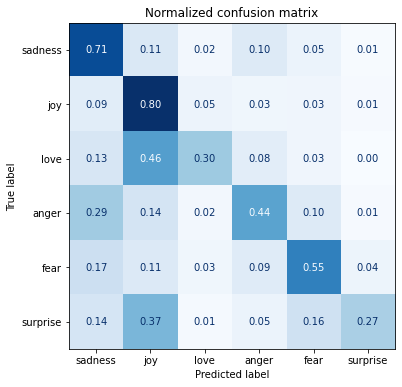

In [36]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)
     


Summary: this procedure does not require a lot of computation power. It is quick in calculation.
The drawback however is, that the accuracy is rather low.

## B: Fine Tuning Transformers

"Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification." 
Quelle: https://github.com/nlp-with-transformers/notebooks/blob/main/02_classification.ipynb

### 1. Loading a pretrained model

"The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the AutoModelForSequenceClassification model instead of AutoModel." 

"The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:"

In [37]:
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
     

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

### 2. Defining the performance metrics

In [38]:
# Computing F1 Score and Accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}
     

In [38]:
# Logging to Hugging Face
#from huggingface_hub import notebook_login
#notebook_login()    


### 3. Training the model

We are using here two methods from Hugging Face: 
Trainer - 
Training Arguments class - "stores a lot of information and gives you fine-grained control over the training and evaluation"

In [39]:
# Specifying Parameters with trainingArguments Class
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [40]:
# Instantiate and fine-tune our model with the Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

C:\Users\aklof\distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/Al3ksandra/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
C:\Users\aklof\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.829500,0.303517,0.919000,0.917347


NotADirectoryError: [WinError 267] Der Verzeichnisname ist ungültig: 'C:\\Users\\aklof\\AppData\\Local\\Temp\\tmph06fs0j7\\lfs_progress'

In [41]:
# Geting predictions on the validation dataset
preds_output = trainer.predict(emotions_encoded["validation"])

In [42]:
preds_output.metrics

{'test_loss': 0.21234478056430817,
 'test_accuracy': 0.929,
 'test_f1': 0.9289049190104718,
 'test_runtime': 93.0009,
 'test_samples_per_second': 21.505,
 'test_steps_per_second': 0.344}

We can decode the predictions using np.argmax(). 

In [43]:
y_preds = np.argmax(preds_output.predictions, axis=1)

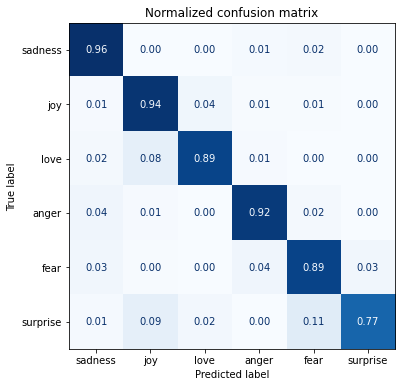

In [45]:
# confusion matrix
plot_confusion_matrix(y_preds, y_valid, labels)    


## Error analysis

In [46]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}
     

In [47]:
# Using the map() method, we can apply this function to get the losses for all the samples:

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


  0%|          | 0/125 [00:00<?, ?ba/s]

In [48]:
# Creating dataframe
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [49]:
# checking the loss function
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.330768
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.223125
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.176204
1274,i am going to several holiday parties and i ca...,joy,sadness,5.108088
1111,im lazy my characters fall into categories of ...,joy,fear,4.871491
1950,i as representative of everything thats wrong ...,surprise,sadness,4.633885
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.577408
465,i would eventually go in to these stores but i...,joy,fear,4.535178
882,i feel badly about reneging on my commitment t...,love,sadness,4.523285
765,i feel super awkward and out of place right now,joy,sadness,4.518948


## Saving Model

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

 Since we've pushed our model to the Hub, we can now use it with the pipeline() function.

## Downloading saved Model

In [52]:
from transformers import pipeline

model_id = "al3ksandra/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

C:\Users\aklof\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:125: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aklof\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
## Making predictions and showing probability

In [53]:
custom_tweet = "Twitter is really funny these days."
preds = classifier(custom_tweet, return_all_scores=True)

C:\Users\aklof\AppData\Roaming\Python\Python39\site-packages\transformers\pipelines\text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [54]:
preds_df = pd.DataFrame(preds[0])

In [55]:
preds_df.head()

,label,score
0,LABEL_0,0.020346
1,LABEL_1,0.032955
2,LABEL_2,0.027043
3,LABEL_3,0.090138
4,LABEL_4,0.171308


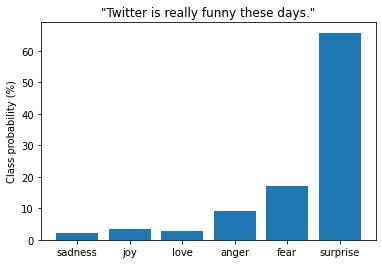

In [56]:


preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()
     
